# Práctica 4. Bolsas de Conceptos

Guillermo Segura Gómez

## DOR. Document Occurrence Representation  

Vamos a realizar el mismo proceso que se realizó cuando se construyó la bolas de palabras, con el mismo set de datos.

In [27]:
# Función para importar textos y etiquetas
def get_text_from_file(path_corpus, path_truth):

    tr_text = []
    tr_labels = []

    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for tweet in f_corpus:
            tr_text += [tweet]
        for label in f_truth:
            tr_labels += [label]

    return tr_text, tr_labels

Necesitamos tokenizar los documentos para posterior construir la bolsa de conceptos. 

In [28]:
path_text = "/Users/guillermo_sego/Desktop/Segundo Semestre/PLN/Data/MexData/mex20_train.txt"
path_labels = "/Users/guillermo_sego/Desktop/Segundo Semestre/PLN/Data/MexData/mex20_train_labels.txt"

tr_text, tr_labels = get_text_from_file(path_text, path_labels)

In [29]:
import nltk
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer() # Inicializar tokenizer

corpus_palabras = []

for doc in tr_text:
    corpus_palabras += tokenizer.tokenize(doc)

fdist = nltk.FreqDist(corpus_palabras)

In [30]:
print(f"El tamaño del corpus es:", len(corpus_palabras))
print(f"El tamaño del vocabulario es:", len(fdist))

El tamaño del corpus es: 97473
El tamaño del vocabulario es: 15194


In [31]:
# Función para ordenar las frecuencias
def  SortFrecuency(freqdist):
    # List comprenhension
    aux = [(freqdist[key], key) for key in freqdist]
    aux.sort() # Ordena la lista
    aux.reverse() # Cambiar el orden

    return aux

In [32]:
voc = SortFrecuency(fdist)
voc = voc[:5000]
voc[:5]

[(3016, ','), (2915, 'de'), (2829, 'que'), (2604, '.'), (2031, 'la')]

Creamos un diccionario.

In [33]:
dict_indices = dict()
count = 0

for weight, word in voc:
    dict_indices[word] = count
    count += 1

dict_indices

{',': 0,
 'de': 1,
 'que': 2,
 '.': 3,
 'la': 4,
 'a': 5,
 'y': 6,
 '!': 7,
 'no': 8,
 '@USUARIO': 9,
 'me': 10,
 'el': 11,
 'en': 12,
 'se': 13,
 'es': 14,
 'con': 15,
 '?': 16,
 'verga': 17,
 'los': 18,
 'madre': 19,
 'por': 20,
 'las': 21,
 '"': 22,
 'un': 23,
 'te': 24,
 'mi': 25,
 'lo': 26,
 'putas': 27,
 'una': 28,
 '...': 29,
 'putos': 30,
 'para': 31,
 '😂': 32,
 'si': 33,
 'ya': 34,
 'como': 35,
 'su': 36,
 'pero': 37,
 'tu': 38,
 'loca': 39,
 'le': 40,
 'más': 41,
 'No': 42,
 'del': 43,
 'gorda': 44,
 'al': 45,
 'bien': 46,
 'A': 47,
 '¿': 48,
 'Y': 49,
 'son': 50,
 'Me': 51,
 'o': 52,
 'feas': 53,
 'cuando': 54,
 'Que': 55,
 ':': 56,
 'yo': 57,
 'les': 58,
 'porque': 59,
 'ni': 60,
 'está': 61,
 'ser': 62,
 'estoy': 63,
 'sus': 64,
 'todos': 65,
 'esta': 66,
 'puta': 67,
 'Ya': 68,
 'todo': 69,
 'pinche': 70,
 'puto': 71,
 'tan': 72,
 'Si': 73,
 'La': 74,
 'qué': 75,
 '…': 76,
 'eso': 77,
 'muy': 78,
 'soy': 79,
 'hasta': 80,
 'así': 81,
 '¡': 82,
 '<URL>': 83,
 'mamar': 84,


Recordando la función realizada de la bolsa de palabras

In [38]:
import numpy as np

def build_bow_binary(tr_text, vocabulary, dict_indices):
    # Construcción de matriz para la bolsa de palabras
    # En cada fila vemos los documentos que estamos procesando
    # En las columnas el tamaño del vocabulario que estamos creando
    BOW = np.zeros((len(tr_text),len(vocabulary)), dtype = int)

    for idx, tr in enumerate(tr_text):

        # Cada documento tr lo tokenizamos
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

        # Contamos cada palabra
        for word in fdist_doc:
            # Nos aseguramos que las palabras estan en el diccionario final
            if word in dict_indices:
                BOW[idx, dict_indices[word]] = 1 # Esquema de pesado binario

    return BOW

Aplicamos la bolsa de palabras al conjunto de entrenamiento.

In [42]:
BOW_tr = build_bow_binary(tr_text, voc, dict_indices)
BOW_tr[:10][:10]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

## Implementación de DOR

Calculamos la bolsa de términos en base a la bolsa de palabras. Queremos una representación (término, documento). Estamos trabajando con el paradigma de textos cortos. 

In [43]:
def compute_dor(TR):

    # Restricciones sobre los subconjuntos de los documentos
    TR_subset_in = TR # Sin condiciones

    # Inicializamos la bolsa de conceptos (opuesta a la bolsa de palabras)
    DTR = np.zeros((TR_subset_in.shape[1], TR_subset_in.shape[0]), dtype=float)

    len_voc = TR_subset_in.shape[1] # Tamaño del vocabulario total

    # Iteramos sobre las filas, es decir cada documento
    for doc, i in zip(TR_subset_in, range(len(TR_subset_in))):
        
        non_zero_positions = np.nonzero(doc)[0] # Medimos elementos no nulos
        len_voc_doc = len(non_zero_positions) # Tamaño del vocabulario en el documento

        # Iteramos sobre los términos y actualizamos la matriz DTR
        for term in non_zero_positions:
            # Asignamos el peso
            DTR[term, i] = (1 + np.log10(doc[term])) * np.log10(len_voc/len_voc_doc)

    return DTR

In [45]:
DOR_base = compute_dor(BOW_tr)
DOR_base[:10][:10]

array([[0.        , 0.        , 0.        , ..., 0.        , 2.49485002,
        2.55284197],
       [2.31875876, 0.        , 2.69897   , ..., 2.85387196, 0.        ,
        2.55284197],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.69897   , ..., 0.        , 0.        ,
        0.        ],
       [2.31875876, 2.4436975 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Vamos a hacer una normalización para poder unificar los valores en los vectores y escribir todo de manera estándar. Reducir la dimensionalidad. Esto se va realizar utilizando **feature selection**. El feature selection selecciona los k mejores utilizando métodos estadísticos. El feature selection ya esta dentro de la liberia `sklearn`. Se trata de determinar cuales son las palabras mas relevantes. Seleccionamos en este caso las 1000 palabra mas relevantes.  

In [46]:
from sklearn.feature_selection import SelectKBest, chi2

feast = SelectKBest(chi2, k=1000)
feast.fit(BOW_tr, tr_labels)

SelectKBest(k=1000, score_func=<function chi2 at 0x1380a65c0>)

In [48]:
# Selección de palabras mas importantes
best = feast.get_support(indices=True)
best[:20]

array([ 0,  1,  2,  4,  5,  7,  9, 10, 11, 12, 17, 18, 19, 22, 24, 25, 28,
       30, 35, 36])

Ahora vamos a construir un diccionario invertido. Es decir teníamos un diccionario que accedía a la frecuencia en función de la palabra, ahora accedemos a la palabra en función de la frecuencia. 

In [49]:
dict_indices_invertido = {}
for w in dict_indices:
    dict_indices_invertido[dict_indices[w]] = w

In [53]:
# Palabras target, después de filtrar las 1000 mas relevantes
target_words = [dict_indices_invertido[index] for index in best]
target_words[:20]

[',',
 'de',
 'que',
 'la',
 'a',
 '!',
 '@USUARIO',
 'me',
 'el',
 'en',
 'verga',
 'los',
 'madre',
 '"',
 'te',
 'mi',
 'una',
 'putos',
 'como',
 'su']

Reducimos el número de palabras en la matriz DOR, y asi nos quedamos con la matriz objetivo

In [54]:
target_matrix = np.array([DOR_base[dict_indices[word]] for word in target_words]) 

In [56]:
target_matrix.shape

(1000, 5278)

Las 1000 palabras mas relevantes en los documentos. 

Ahora si reducimos la dimensionalidad. Podemos hacerlo con cualquier técnica, en este caso utilizamos `tsne`

In [61]:
from sklearn.manifold import TSNE

# Crea una instancia de TSNE
tsne = TSNE(n_components=2)  # n_components=2 indica el número de dimensiones a las que quieres reducir tus datos

# Utiliza fit_transform para reducir la dimensionalidad
reduced_matrix = tsne.fit_transform(target_matrix)

Parámetros para graficar. La gráfica nos va permitir visualizar las correlaciones entre las palabras. Además también podemos visualizar las stopwords dentro del mapa. 

In [63]:
max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

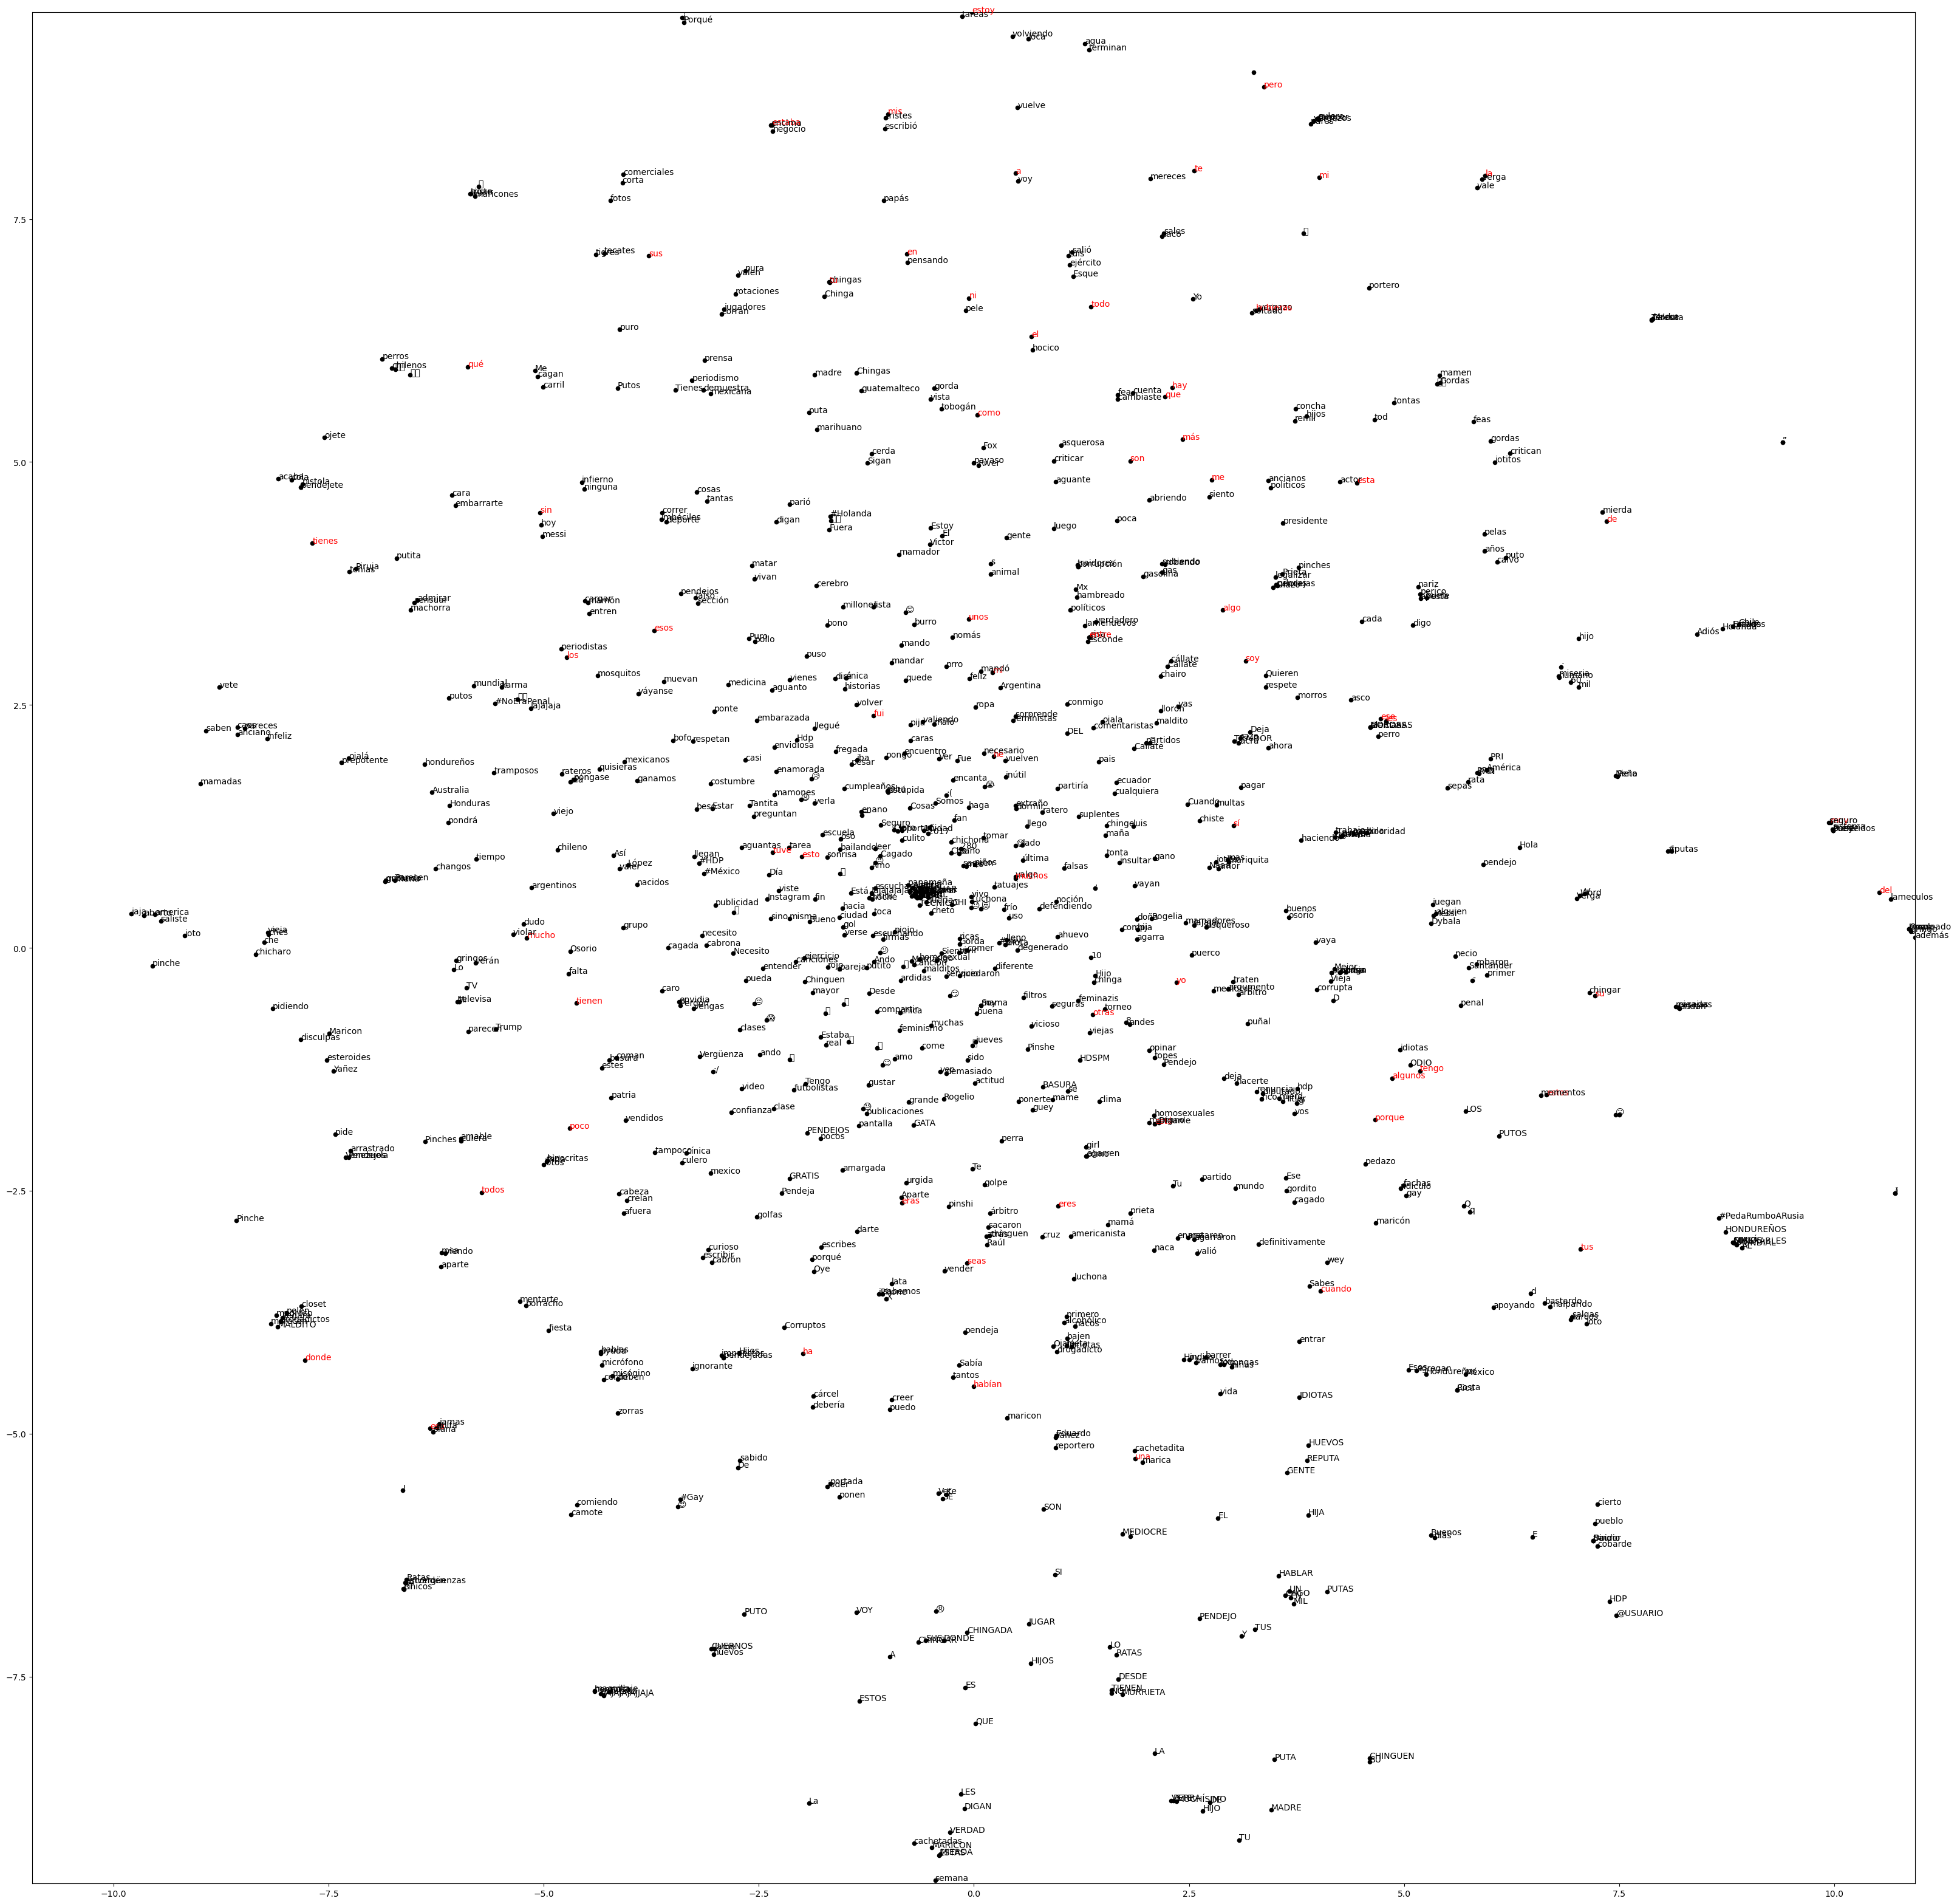

In [73]:
import matplotlib.pyplot as plt
import warnings
import nltk
nltk.data.path.append('/Users/guillermo_sego/anaconda3/nltk_data/') # path

# Suprimir advertencias
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
sw = set(stopwords.words("spanish"))

plt.figure(figsize=[40, 40], dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))

plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color="black")

for idx, word in enumerate(target_words[:]):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    
    if word in sw:
        plt.annotate(word, (x, y), color="red")
    else:
        plt.annotate(word, (x, y), color="black")



Las palabras con contextos similares se comienzan a agrupar en esta representación. 

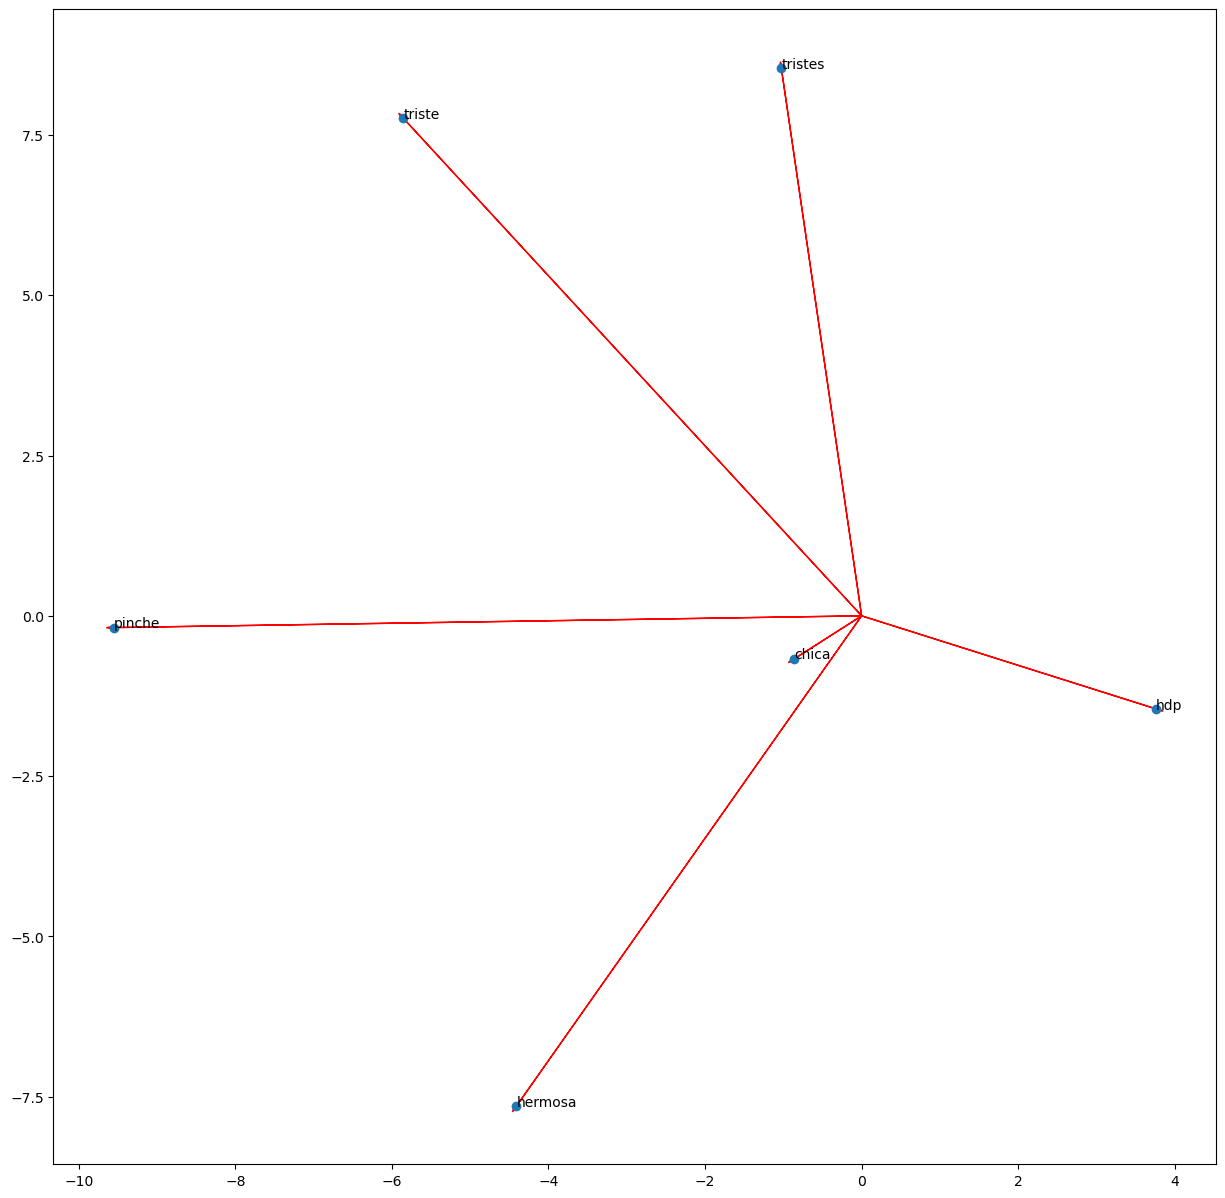

In [84]:
subsetwords = ["tristes", "triste", "alegría", "hermosa", "chica", "hombres", "hdp", "felicidad", "explosión", "señor", "pinche"]

ploted_subsetwords = []
subreduced_matrix = []

for idx, word in enumerate(target_words):
    if word in subsetwords:
        ploted_subsetwords.append(word)
        subreduced_matrix.append(reduced_matrix[idx])

subreduced_matrix = np.array(subreduced_matrix)

fig, ax = plt.subplots(figsize=(15, 15))

for i, word in enumerate(subreduced_matrix):
    ax.arrow(0, 0, word[0], word[1], head_width=0.05, head_length=0.1, fc='r', ec='r')
    ax.annotate(ploted_subsetwords[i], (word[0], word[1]))

ax.scatter(subreduced_matrix[:, 0], subreduced_matrix[:, 1])
plt.show()
